In [255]:
# !python3 -m pip install matplotlib
# !python3 -m pip install scipy

In [256]:
import xarray as xr
import matplotlib
import csv
import dask

In [257]:
RUN_NAME = "LW_CLM_Ex4_24"
ds = xr.open_dataset(f"{RUN_NAME}/{RUN_NAME}.out.pfmetadata")

LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.press.00000.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.satur.00000.pfb
LW_CLM_Ex4_24/../parflow_input/LW.dem.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.DSWR.000001_to_000024.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.DLWR.000001_to_000024.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.APCP.000001_to_000024.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.Temp.000001_to_000024.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.UGRD.000001_to_000024.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.Press.000001_to_000024.pfb
LW_CLM_Ex4_24/../NLDAS//NLDAS.SPFH.000001_to_000024.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.perm_x.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.perm_y.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.perm_z.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.porosity.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.specific_storage.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.mannings.pfb
LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.mask.pfb


In [258]:
# select the surface layer
ds = ds.sel(z=-1)


In [259]:
# ds = ds.drop_vars(["precipitation", "downward shortwave radiation", "downward longwave radiation", "temperature", "wind velocity", "atmospheric pressure", "specific humidity"])
ds

<xarray.Dataset>
Dimensions:                       (time: 24, y: 41, x: 41)
Dimensions without coordinates: time, y, x
Data variables: (12/17)
    pressure                      (time, y, x) float64 ...
    saturation                    (time, y, x) float64 ...
    elevation                     (y, x) float64 ...
    downward shortwave radiation  (time, y, x) float64 ...
    downward longwave radiation   (time, y, x) float64 ...
    precipitation                 (time, y, x) float64 ...
    ...                            ...
    permeability_y                (y, x) float64 ...
    permeability_z                (y, x) float64 ...
    porosity                      (y, x) float64 ...
    specific storage              (y, x) float64 ...
    mannings                      (y, x) float64 ...
    mask                          (y, x) float64 ...
Attributes:
    pf_metadata_file:  LW_CLM_Ex4_24/LW_CLM_Ex4_24.out.pfmetadata
    parflow_version:   v3.9.0-131-g0173f768

In [260]:
future_ds = ds.shift(time = -1)

In [261]:
# We add a new variable to the dataset that indicates whether we switch to positive pressure
# at the next time step
BOUNDARY_PRESSURE = 0
current_pressure_is_negative = ds.pressure.where(ds.pressure < BOUNDARY_PRESSURE, 0)
current_pressure_is_negative = current_pressure_is_negative.where(ds.pressure > BOUNDARY_PRESSURE, 1)
next_pressure_is_positive = future_ds.pressure.where(future_ds.pressure < BOUNDARY_PRESSURE, 1)
next_pressure_is_positive = next_pressure_is_positive.where(future_ds.pressure > BOUNDARY_PRESSURE, 0)
ds = ds.assign(pressure_becomes_positive = next_pressure_is_positive * current_pressure_is_negative)
# ds = ds.assign(next_pressure = future_ds.pressure)


In [262]:
# ds.sel(time=150).pressure_becomes_positive.plot()

In [263]:
def times_with_pressure_changes(ds, BOUNDARY_PRESSURE=0.0):
    for time in ds.time:
        if ds.sel(time=time).pressure_becomes_positive.sum() > 0:
            yield int(time)

print(list(times_with_pressure_changes(ds, BOUNDARY_PRESSURE=BOUNDARY_PRESSURE)))

[0, 4, 6, 9, 12, 13, 16, 17, 19, 21]


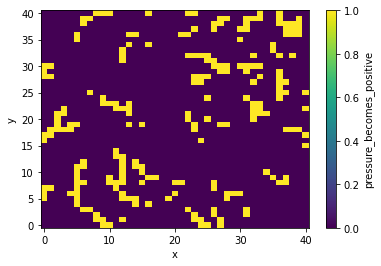

In [264]:
ds.sel(time=4).pressure_becomes_positive.plot()

In [265]:
# # df = pd.read_csv("LW_CLM_Ex3_save/predictor_training_output.csv")

# import linecache

# from pandas import DataFrame

# filename = "LW_CLM_Ex3_short_run/predictor_training_output.csv"
# indices = range(1,3)

# li = []
# for i in indices:
#     li.append(linecache.getline(filename, i).rstrip().split(','))

# print(li[0])
# df2 = DataFrame(li)

In [266]:
import pandas as pd

filename = f"{RUN_NAME}/predictor_training_output.csv"
df = pd.read_csv(filename)
df = df.rename(columns={"i":"x", "j":"y", "pressure":"runtime_pressure"})
pf_ds = df.set_index(["time", "y", "x"]).to_xarray()

pf_ds = pf_ds.shift(time=-1)
pf_ds = pf_ds
# pf_ds.sel(time=110).runtime_pressure.plot()

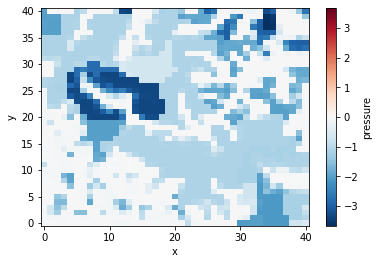

In [267]:
ds.sel(time=2).pressure.plot()

In [268]:
ds = xr.merge([ds, pf_ds], join="inner").sel(time=slice(0, ds.time.shape[0] - 1))
ds = ds.assign(we_predicted = ds.we_predicted == 1)


In [269]:
ds.to_netcdf(f"{RUN_NAME}/training_data.nc")

In [270]:
data = ds.to_dataframe()
data = data[data['pressure'] < 0]
data

pressure  saturation  elevation  downward shortwave radiation  \
time y  x                                                                   
1.0  0  0  -0.091495    0.999841      381.0                           0.0   
        1  -0.095840    0.999752      373.5                           0.0   
        2  -0.096856    0.999693      376.0                           0.0   
        3  -0.110402    0.998995      379.0                           0.0   
        4  -0.103605    0.999357      376.0                           0.0   
...              ...         ...        ...                           ...   
23.0 40 35 -3.001223    0.421740      344.0                           0.0   
        36 -0.122891    0.996883      336.0                           0.0   
        38 -0.224773    0.994849      333.0                           0.0   
        39 -1.371946    0.818873      331.0                           0.0   
        40 -2.652118    0.488542      339.0                           0.0   

            downward longwave radiation  precipitation  temperature  \
time y  x                                                             
1.0  0  0                    306.270073            0.0   290.433755   
        1                    306.128876            0.0   290.413569   
        2                    306.025769            0.0   290.399038   
        3                    305.922426            0.0   290.384448   
        4                    305.818848            0.0   290.369800   
...                                 ...            ...          ...   
23.0 40 35                   321.290788            0.0   293.774016   
        36                   321.406982            0.0   293.788713   
        38                   321.457061            0.0   293.786492   
        39                   321.481616            0.0   293.785296   
        40                   321.505832            0.0   293.784036   

            wind velocity  atmospheric pressure  specific humidity  ...  \
time y  x                                                           ...   
1.0  0  0       -1.394607          97041.266161           0.008222  ...   
        1       -1.376656          97048.163216           0.008218  ...   
        2       -1.362341          97059.479996           0.008217  ...   
        3       -1.348062          97070.817153           0.008216  ...   
        4       -1.333818          97082.174566           0.008215  ...   
...                   ...                   ...                ...  ...   
23.0 40 35      -1.858082          96932.954382           0.010111  ...   
        36      -1.862137          96953.730919           0.010108  ...   
        38      -1.867813          96946.859476           0.010090  ...   
        39      -1.870671          96943.284038           0.010080  ...   
        40      -1.873542          96939.618777           0.010071  ...   

            specific storage  mannings     mask  pressure_becomes_positive  \
time y  x                                                                    
1.0  0  0            0.00001  0.000006  99999.0                        0.0   
        1            0.00001  0.000006  99999.0                        1.0   
        2            0.00001  0.000006  99999.0                        0.0   
        3            0.00001  0.000006  99999.0                        0.0   
        4            0.00001  0.000006  99999.0                        0.0   
...                      ...       ...      ...                        ...   
23.0 40 35           0.00001  0.000006  99999.0                        0.0   
        36           0.00001  0.000006  99999.0                        0.0   
        38           0.00001  0.000006  99999.0                        0.0   
        39           0.00001  0.000006  99999.0                        0.0   
        40           0.00001  0.000006  99999.0                        0.0   

                   volume  max_volume    flux_in  runtime_pressure  \
time y  x                

In [271]:
import xarray as xr
from xgboost import XGBClassifier
import sklearn
import numpy as np

In [272]:
features = [
    "pressure", "saturation", "volume", "max_volume", "flux_in", "we_predicted", 
    "permeability_x", "permeability_y", "permeability_z", "porosity", "specific storage", "mannings",
    ]
atmospheric_features = [
    "precipitation", "downward shortwave radiation", "downward longwave radiation", "temperature", 
    "wind velocity", "atmospheric pressure", "specific humidity"
]
features += atmospheric_features
# features += atmospheric_features
target = ["pressure_becomes_positive"]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data[features], data[target], test_size=.2)


/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Confusion matrix for our Linear predictor')

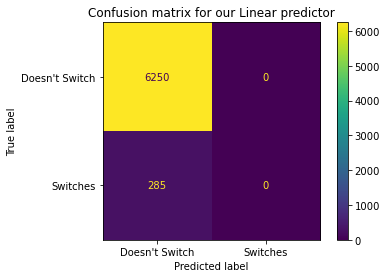

In [273]:
from sklearn.linear_model import RidgeClassifier

linear_model = RidgeClassifier().fit(x_train, y_train)

preds = linear_model.predict(x_test)

disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test[target],
    preds,
    display_labels=["Doesn't Switch", "Switches"]
    )
disp.ax_.set_title("Confusion matrix for our Linear predictor")

In [274]:
params = {
            'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 1.0],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.5, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
            'n_estimators': [25, 50, 100],
            'max_depth': [2,4,8,16]
        }

xgbclf = XGBClassifier(objective="binary:logistic")
model = sklearn.model_selection.RandomizedSearchCV(estimator=xgbclf,
                            param_distributions=params,
                            scoring='roc_auc',
                            n_iter=5,
                            n_jobs=4,
                            verbose=1)

model.fit(x_train, y_train)


best_combination = model.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [275]:
best_model = model.best_estimator_
preds = best_model.predict(x_test)
print(best_combination)

{'subsample': 0.7999999999999999, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.4, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7999999999999999}


Text(0.5, 1.0, 'Confusion matrix for our XGBoost predictor')

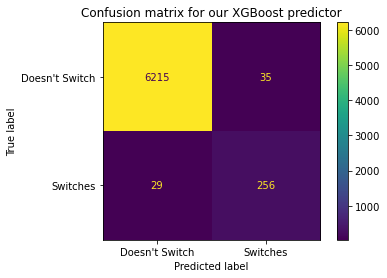

In [276]:
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test[target], 
    preds,
    display_labels=["Doesn't Switch", "Switches"]
    )
disp.ax_.set_title("Confusion matrix for our XGBoost predictor")

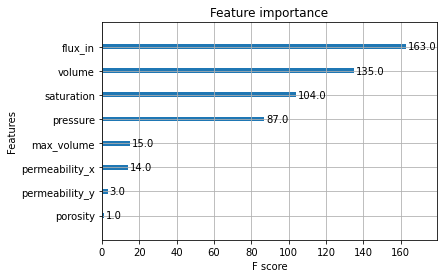

In [277]:
from matplotlib import pyplot

# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(best_model)
pyplot.show()